In [22]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [23]:
def create_models(server_datasets):

    best_neighbors = []
    best_f1_scores = []
    model_instance_list = []
    dataset_sizes = []
        
    
    for df_train, df_test in (server_datasets):
        params1 = {"n_neighbors": np.arange(3, 51, 2)}
        knn = KNeighborsClassifier()
        model1 = GridSearchCV(knn, params1, scoring='f1_macro', cv=2, n_jobs=-1)
        # params2 = {"n_estimators": np.array([50, 100, 150, 200]), "max_depth": np.array([3, 5, 8, 10, 15])}
        # random_forests = RandomForestClassifier()
        # model2 = GridSearchCV(random_forests, params2, scoring='f1_macro', cv=2, n_jobs=-1)
        
        X_s_train = df_train.drop(['Class'], axis=1)
        y_s_train = df_train['Class']
        X_s_test = df_test.drop(['Class'], axis=1)
        y_s_test = df_test['Class']
        
        model1.fit(X_s_train, y_s_train)
        # model2.fit(X_s_train, y_s_train)
        y_pred = model1.predict(X_s_test)
        
        best_neighbors.append(model1.best_params_['n_neighbors'])
        best_f1_scores.append(f1_score(y_s_test, y_pred, average='macro'))
        model_instance_list.append({
            'dist_model': model1,
            'prob_model': model1
        })
        
        # # Compute median distances (possible logical flaw)
        # nbrs = model.best_estimator_
        # distances, indices = nbrs.kneighbors(X_s_train)
        # distances_no_self = distances[:, 1:]
        # median_neighbor_distance.append(np.median(distances_no_self))
        
        dataset_sizes.append(df_train.shape[0])

    return (best_neighbors, best_f1_scores, model_instance_list, dataset_sizes)

In [24]:
class ModelPerformanceAnalyzer:
    def __init__(self, models, model_names = None): # models : {dist_model: (knn model for neighbor), prob_model: (rf model for probabilities)}
        self.models = models
        self.model_names = model_names or [f"Model_{i}" for i in range(len(models))]
        self.performance_df = None
    
    def analyze_models(self, X_unseen, y_unseen):
        results = []
        for i, (model, name) in enumerate(zip(self.models, self.model_names)):
            
            model_metrics = self._analyze_single_model(
                model, name, i, X_unseen, y_unseen
            )
            results.append(model_metrics)
        
        self.performance_df = pd.DataFrame(results)
        return self.performance_df
    
    
    def _analyze_single_model(self, model, name, index, X_unseen, y_unseen):

        #Predictions and probabilities
        y_pred = model['prob_model'].predict(X_unseen)
        y_proba = model['prob_model'].predict_proba(X_unseen)

        #Distance metrics

        metrics = {
            'model_name': name,
            'model_index': index,
            'f1_score': f1_score(y_unseen, y_pred, average='macro'),
            'classification_probabilities': y_proba.tolist()
        }

        distance_metrics = self._calculate_distance_metrics(model['dist_model'], X_unseen)
        metrics.update(distance_metrics)
        return metrics


    def _calculate_distance_metrics(self, model, X_unseen):
        """Calculate various distance-based metrics."""
        try:
            nbrs = model.best_estimator_
            
            # Calculate distance matrix
            distances, indices = nbrs.kneighbors(X_unseen)
            distances_no_self = distances
            
            # Various distance statistics
            point_medians = np.median(distances_no_self, axis=1)
            point_means = np.mean(distances_no_self, axis=1)
            point_mins = np.min(distances_no_self, axis=1)
            point_maxs = np.max(distances_no_self, axis=1)
            
            return {
                'median_distance_all_points': np.median(point_medians),
                'mean_distance_all_points': np.mean(point_means),
                'min_distance_all_points': np.min(point_mins),
                'max_distance_all_points': np.max(point_maxs),
                'distance_std': np.std(distances_no_self),
            }
        except Exception as e:
            warnings.warn(f"Distance calculation failed for model: {e}")
            return {
                'median_distance_all_points': np.nan,
                'mean_distance_all_points': np.nan,
                'min_distance_all_points': np.nan,
                'max_distance_all_points': np.nan,
                'distance_std': np.nan,
            }
    def get_probability_matrix(self, model_index):
        """Get probability matrix for a specific model as numpy array."""
        if self.performance_df is not None:
            return np.array(self.performance_df.loc[model_index, 'classification_probabilities'])
        return None
    
    def get_all_probabilities(self):
        """Get all probability matrices as a 3D array (models x samples x classes)."""
        if self.performance_df is not None:
            return np.array([np.array(probs) for probs in self.performance_df['classification_probabilities']])
        return None

In [25]:
def run_distributed_knn_simulation(data_train,data_test, n_simulations=10, n_servers=100, test_size=0.2):
    """
    Optimized version using ModelPerformanceAnalyzer for probability extraction
    """
    simulation_results = []

    all_medians = []
    all_means = []
    
    for sim in range(n_simulations):
        print(f"Running simulation {sim+1}/{n_simulations}")
        
        # 1. Split data
        X_train_full = data_train.drop(['Class'], axis=1)
        y_train_full = data_train['Class']

        X_test_heldout = data_test.drop(['Class'], axis=1)
        y_test_heldout = data_test['Class']
        
        
        # 2. Generate server datasets
        def generate_server_datasets(train_pool, test_pool, n_servers=100,
                                    min_samples=1000, max_samples=5000):

            server_datasets = []

            X_train_pool = train_pool.drop(columns=["Class"])
            y_train_pool = train_pool["Class"]

            X_test_pool = test_pool.drop(columns=["Class"])
            y_test_pool = test_pool["Class"]

            for seed in range(n_servers):

                # -------------------------
                # train subset
                # -------------------------
                train_size = np.random.randint(min_samples, max_samples)

                sss_train = StratifiedShuffleSplit(
                    n_splits=1,
                    train_size=train_size,
                    random_state=seed
                )

                train_idx, _ = next(sss_train.split(X_train_pool, y_train_pool))
                server_train = train_pool.iloc[train_idx]

                # -------------------------
                # test subset (0.3x)
                # -------------------------
                test_size = int(0.3 * train_size)

                sss_test = StratifiedShuffleSplit(
                    n_splits=1,
                    train_size=test_size,
                    random_state=seed
                )

                test_idx, _ = next(sss_test.split(X_test_pool, y_test_pool))
                server_test = test_pool.iloc[test_idx]

                server_datasets.append((server_train, server_test))

            return server_datasets

        
        train_pool_df = pd.concat([X_train_full, y_train_full], axis=1)
        test_pool_df  = pd.concat([X_test_heldout, y_test_heldout], axis=1)

        server_datasets = generate_server_datasets(
            train_pool_df,
            test_pool_df,
            n_servers=n_servers
        )

        
        # 3. Train models
        best_neighbors, best_f1_scores, model_instance_list, dataset_sizes = create_models(server_datasets)
        
        metrics_df = pd.DataFrame({
            'optimal_k_value': best_neighbors,
            'best_f1_scores': best_f1_scores,
            'model_instance': model_instance_list,
            'dataset_size': dataset_sizes
        })

        metrics_df = metrics_df[metrics_df['best_f1_scores'] != 0]
        
        # 4. Test on held-out data
        n_test_samples = min(500, len(X_test_heldout))
        test_indices = np.random.choice(len(X_test_heldout), size=n_test_samples, replace=False)
        X_test_samples = X_test_heldout.iloc[test_indices]
        y_test_true = y_test_heldout.iloc[test_indices]

        # Use ModelPerformanceAnalyzer to get all metrics and probabilities
        analyzer = ModelPerformanceAnalyzer(metrics_df['model_instance'].tolist())
        analysis_df = analyzer.analyze_models(X_test_samples, y_test_true)
        
        # Merge results
        metrics_df = metrics_df.merge(
            analysis_df[['model_index', 'median_distance_all_points', 'mean_distance_all_points']], 
            left_index=True, 
            right_on='model_index'
        )
        
        all_medians.extend(metrics_df['median_distance_all_points'].tolist())
        all_means.extend(metrics_df['mean_distance_all_points'].tolist())
        
        # Define scoring functions
        def arctan_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 0.5 + (np.arctan(((max_d + min_d)/2) - distance)/np.pi)
        
        def tanh_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 0.5 + 0.5*(np.tanh(((max_d + min_d)/2) - distance))
        
        def sigmoid_score(distance, df):
            min_d = df['median_distance_all_points'].min()
            max_d = df['median_distance_all_points'].max()
            return 1 / (1 + 2*np.exp(((max_d + min_d)/2) - distance))
        
        def relu_score(distance, df):
            mean = df['mean_distance_all_points'].mean()
            deviation = df['mean_distance_all_points'].std()
            score = (mean + 2 * deviation - distance) if (mean + 2 * deviation - distance) > 0 else 0
            return score
        
        
        # Calculate scores
        metrics_df['arctan_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: arctan_score(x, metrics_df)
        )
        metrics_df['tanh_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: tanh_score(x, metrics_df)
        )
        metrics_df['sigmoid_score'] = metrics_df['median_distance_all_points'].apply(
            lambda x: sigmoid_score(x, metrics_df)
        )
        metrics_df['relu_score'] = metrics_df['mean_distance_all_points'].apply(
            lambda x: relu_score(x, metrics_df)
        )
        # Extract probabilities from analyzer (more efficient)
        probability_list = []
        for i in range(len(X_test_samples)):
            point_probs = []
            for model_idx in range(len(metrics_df)):
                model_probs = analyzer.get_probability_matrix(model_idx)
                point_probs.append(model_probs[i])
            probability_list.append(point_probs)
        
        probability_list = np.array(probability_list)
        
        # Calculate weighted predictions
        approaches = {
            'approach_1': 'arctan_score',
            'approach_2': 'dataset_size', 
            'approach_3': 'tanh_score',
            'approach_4': 'sigmoid_score',
            'approach_5': 'relu_score'
        }
        
        approach_preds = {}
        for approach_name, weight_col in approaches.items():
            if weight_col == 'dataset_size':
                weights = metrics_df[weight_col].values
            else:
                weights = metrics_df[weight_col].values
            
            weighted_results = []
            for probability in probability_list:
                weighted = probability * weights.reshape(-1, 1)
                weighted_results.append(weighted.sum(axis=0) / weights.sum())
            
            approach_preds[approach_name] = np.array([np.argmax(p) for p in weighted_results])
        
        # Calculate metrics
        sim_result = {'simulation': sim}
        for approach_name, preds in approach_preds.items():
            sim_result[f'{approach_name}_f1'] = f1_score(y_test_true, preds, average='macro')
            sim_result[f'{approach_name}_acc'] = accuracy_score(y_test_true, preds)
        
        sim_result.update({
            'n_servers': len(metrics_df),
            'avg_dataset_size': metrics_df['dataset_size'].mean(),
            'avg_median_distance': metrics_df['median_distance_all_points'].mean()
        })
        
        simulation_results.append(sim_result)
    
    return pd.DataFrame(simulation_results), all_medians, all_means

In [26]:
# %%
# Load your data
# data_train = pd.read_csv('/kaggle/input/oelp-dataset/adult_preprocessed_train.csv')
# data_test = pd.read_csv('/kaggle/input/oelp-dataset/adult_preprocessed_test.csv')

data_train = pd.read_csv('../data/dry_bean_train.csv')
data_test = pd.read_csv('../data/dry_bean_test.csv')

# Run multiple simulations
results_df, all_medians, all_means = run_distributed_knn_simulation(data_train, data_test, n_simulations=5, n_servers=10)

Running simulation 1/5
Running simulation 2/5
Running simulation 3/5
Running simulation 4/5
Running simulation 5/5


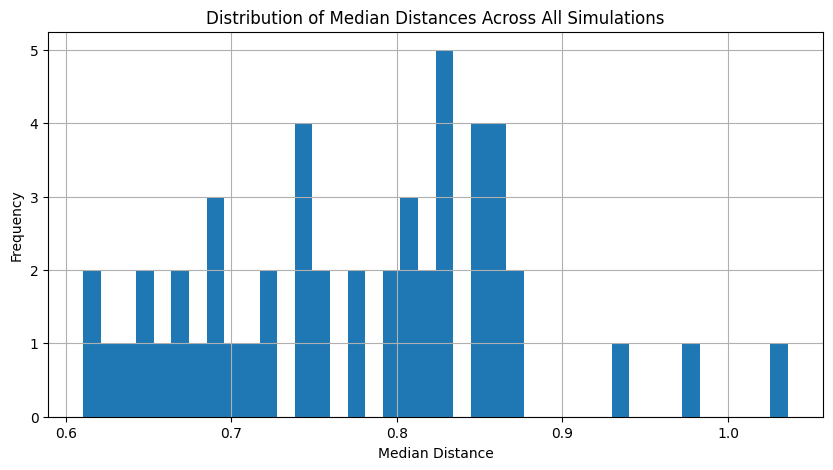

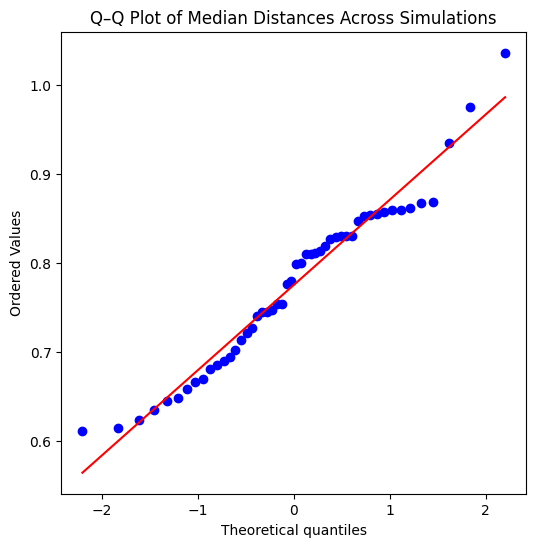

In [27]:
import scipy.stats as stats

plt.figure(figsize=(10, 5))
plt.hist(all_medians, bins=40)
plt.title('Distribution of Median Distances Across All Simulations')
plt.xlabel('Median Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(all_medians, dist="norm", plot=plt)
plt.title('Q–Q Plot of Median Distances Across Simulations')
plt.show()

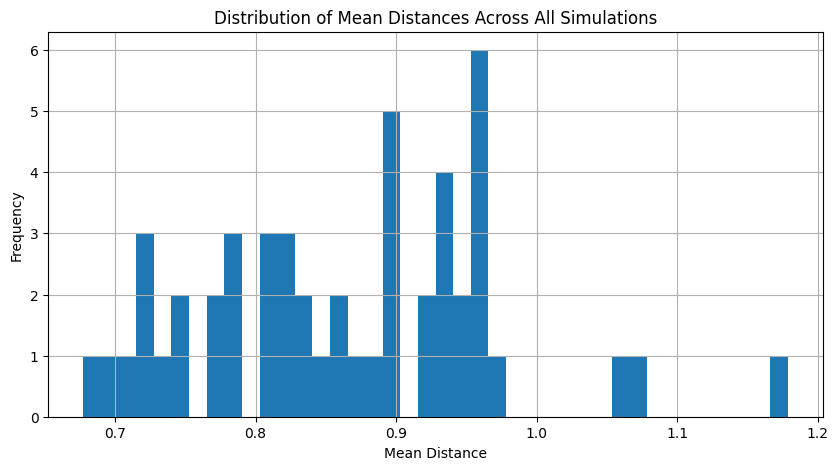

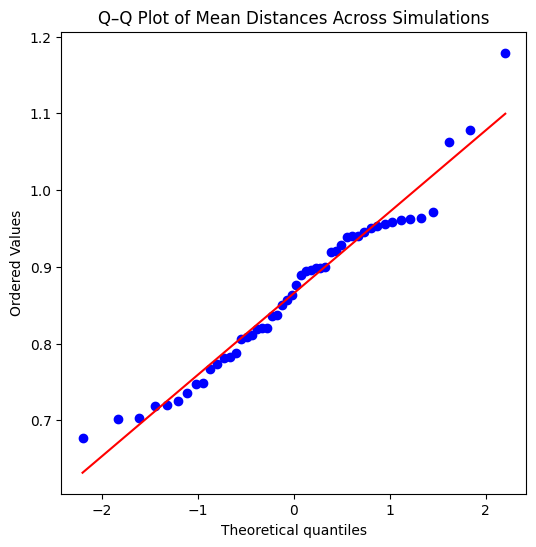

In [28]:
import scipy.stats as stats

plt.figure(figsize=(10, 5))
plt.hist(all_means, bins=40)
plt.title('Distribution of Mean Distances Across All Simulations')
plt.xlabel('Mean Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(all_means, dist="norm", plot=plt)
plt.title('Q–Q Plot of Mean Distances Across Simulations')
plt.show()

In [29]:
# Find the best KNN on overall data
X_train = data_train.drop(['Class'], axis=1)
y_train = data_train['Class']
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']

params1 = {"n_neighbors": np.arange(3, 51, 2)}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params1, scoring='f1_macro', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Best Params: {model.best_params_}")
print(f"Best F1 Score: {f1_score(y_test, y_pred, average='macro')}")

benchmark_f1 = f1_score(y_test, y_pred, average='macro')

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       265
           1       1.00      1.00      1.00       104
           2       0.91      0.94      0.93       326
           3       0.90      0.91      0.91       709
           4       0.96      0.95      0.95       386
           5       0.95      0.94      0.94       406
           6       0.84      0.87      0.85       527

    accuracy                           0.91      2723
   macro avg       0.93      0.92      0.93      2723
weighted avg       0.91      0.91      0.91      2723

Best Params: {'n_neighbors': np.int64(7)}
Best F1 Score: 0.9265320936551327


In [30]:
# %%
# Analyze results
print("Simulation Results Summary:")
print("=" * 50)
print(f"Number of simulations: {len(results_df)}")
print(f"Average F1 Scores:")
print(f"Approach 1 (Arctan): {results_df['approach_1_f1'].mean():.4f} ± {results_df['approach_1_f1'].std():.4f}")
print(f"Approach 2 (Size):   {results_df['approach_2_f1'].mean():.4f} ± {results_df['approach_2_f1'].std():.4f}")
print(f"Approach 3 (Tanh):   {results_df['approach_3_f1'].mean():.4f} ± {results_df['approach_3_f1'].std():.4f}")
print(f"Approach 4 (Sigmoid):   {results_df['approach_4_f1'].mean():.4f} ± {results_df['approach_4_f1'].std():.4f}")
print(f"Approach 4 (Sigmoid):   {results_df['approach_5_f1'].mean():.4f} ± {results_df['approach_5_f1'].std():.4f}")


Simulation Results Summary:
Number of simulations: 5
Average F1 Scores:
Approach 1 (Arctan): 0.9215 ± 0.0141
Approach 2 (Size):   0.9208 ± 0.0130
Approach 3 (Tanh):   0.9222 ± 0.0142
Approach 4 (Sigmoid):   0.9213 ± 0.0139
Approach 4 (Sigmoid):   0.9209 ± 0.0120


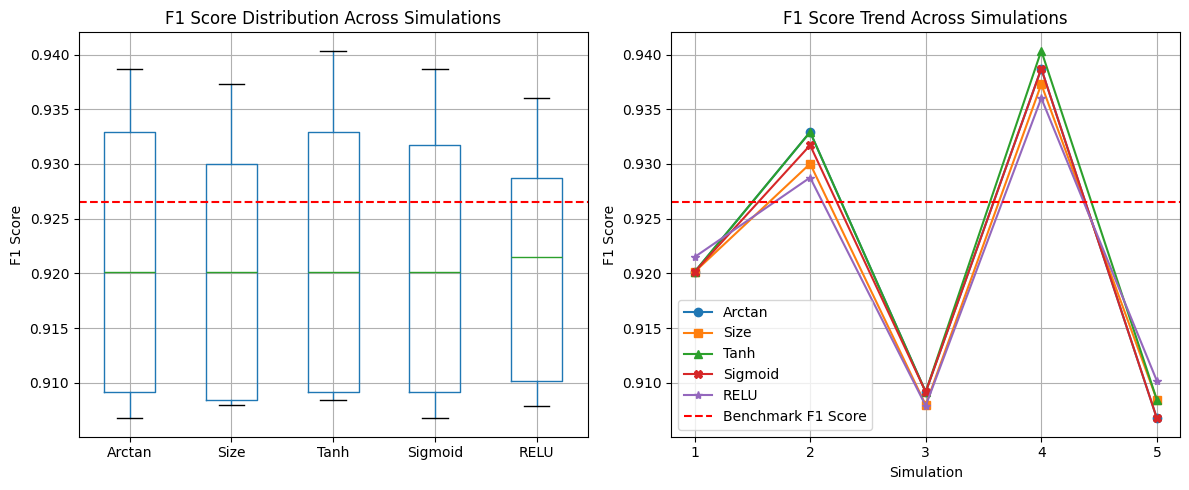

In [31]:
# %%
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
results_df[['approach_1_f1', 'approach_2_f1', 'approach_3_f1', 'approach_4_f1', 'approach_5_f1']].boxplot()
plt.title('F1 Score Distribution Across Simulations')
plt.ylabel('F1 Score')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks([1, 2, 3, 4, 5], ['Arctan', 'Size', 'Tanh', 'Sigmoid', 'RELU'])

plt.subplot(1, 2, 2)
plt.plot(results_df['approach_1_f1'], label='Arctan', marker='o')
plt.plot(results_df['approach_2_f1'], label='Size', marker='s')
plt.plot(results_df['approach_3_f1'], label='Tanh', marker='^')
plt.plot(results_df['approach_4_f1'], label='Sigmoid', marker='X')
plt.plot(results_df['approach_5_f1'], label='RELU', marker='*')
plt.axhline(y=benchmark_f1, color='r', linestyle='--', label='Benchmark F1 Score')
plt.xticks(np.arange(len(results_df)), np.arange(1, len(results_df)+1))
plt.xlabel('Simulation')
plt.ylabel('F1 Score')
plt.title('F1 Score Trend Across Simulations')
plt.legend()
plt.grid(True)

# plt.savefig('../plots/f1_score_trends_std_normal.png')

plt.tight_layout()
plt.show()


In [32]:
# %%
# Statistical significance testing
from scipy.stats import ttest_rel

# Pairwise t-tests
t_stat_1_2, p_val_1_2 = ttest_rel(results_df['approach_1_f1'], results_df['approach_2_f1'])
t_stat_1_3, p_val_1_3 = ttest_rel(results_df['approach_1_f1'], results_df['approach_3_f1'])
t_stat_2_3, p_val_2_3 = ttest_rel(results_df['approach_2_f1'], results_df['approach_3_f1'])
t_stat_2_4, p_val_2_4 = ttest_rel(results_df['approach_2_f1'], results_df['approach_4_f1'])
t_stat_3_4, p_val_3_4 = ttest_rel(results_df['approach_3_f1'], results_df['approach_4_f1'])
t_stat_1_4, p_val_1_4 = ttest_rel(results_df['approach_1_f1'], results_df['approach_4_f1'])

print("\nStatistical Significance (paired t-tests):")
print(f"Arctan vs Size: p-value = {p_val_1_2:.4f}")
print(f"Arctan vs Tanh: p-value = {p_val_1_3:.4f}")
print(f"Size vs Tanh: p-value = {p_val_2_3:.4f}")
print(f"Size vs Sigmoid: p-value = {p_val_2_4:.4f}")
print(f"Tanh vs Sigmoid: p-value = {p_val_3_4:.4f}")
print(f"Arctan vs Sigmoid: p-value = {p_val_1_4:.4f}")


Statistical Significance (paired t-tests):
Arctan vs Size: p-value = 0.3762
Arctan vs Tanh: p-value = 0.1779
Size vs Tanh: p-value = 0.0997
Size vs Sigmoid: p-value = 0.4499
Tanh vs Sigmoid: p-value = 0.0753
Arctan vs Sigmoid: p-value = 0.3739
